In [2]:
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import torch
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
import torch.nn.functional as F
from matplotlib import pyplot as plt
from pydensecrf.utils import create_pairwise_bilateral, create_pairwise_gaussian
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 15))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [2]:
H, W, num_classes = 5000, 1400, 7
res = np.load("/data/home/nanwang/research/four_pixel/huaxing/20210607/hrv2_attenunet/result/val/10000/result/home/nanwang/data/research/four_pixel/20210527_crop/碎角裂纹_0.bmp.npy",allow_pickle=True).item()
scores = res["predict_scores"]
tensor = torch.tensor(scores)
prob_map = F.softmax(tensor,dim=0)
prob_map = prob_map.detach().numpy()
pre_mask = np.argmax(scores,axis=0)

In [3]:
U = unary_from_softmax(prob_map)
d = dcrf.DenseCRF2D(W, H, num_classes)
d.setUnaryEnergy(U)
Q_unary = d.inference(10)
map_soln_unary = np.argmax(Q_unary, axis=0)
mask_soln_unary = map_soln_unary.reshape(H,W)

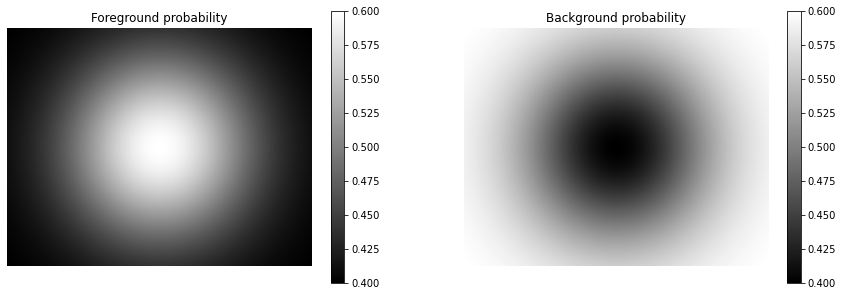

In [3]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
H, W, NLABELS = 400, 512, 2

# This creates a gaussian blob...
pos = np.stack(np.mgrid[0:H, 0:W], axis=2)
rv = multivariate_normal([H//2, W//2], (H//4)*(W//4))
probs = rv.pdf(pos)

# ...which we project into the range [0.4, 0.6]
probs = (probs-probs.min()) / (probs.max()-probs.min())
probs = 0.5 + 0.2 * (probs-0.5)

# The first dimension needs to be equal to the number of classes.
# Let's have one "foreground" and one "background" class.
# So replicate the gaussian blob but invert it to create the probability
# of the "background" class to be the opposite of "foreground".
probs = np.tile(probs[np.newaxis,:,:],(2,1,1))
probs[1,:,:] = 1 - probs[0,:,:]

# Let's have a look:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(probs[0,:,:]); plt.title('Foreground probability'); plt.axis('off'); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(probs[1,:,:]); plt.title('Background probability'); plt.axis('off'); plt.colorbar();

In [61]:
## warp function
def pp_denseCRF(imag, y_pred,
                pairwise_gauss=True, pairwise_bilateral=True,
                pw_gauss_sdims=(1, 1), pw_gauss_compat=1,
                pw_bilat_sdims=(3, 3), pw_bilat_schan=(1,),
                pw_bilat_compat=10, inf_steps=5):
    '''Dense CRF postprocessing using 2D image / softmax prediction matrix
    y_pred : H, W, n_classes
    '''
    height, width, channels = imag.shape
    n_classes = y_pred.shape[-1]
    
    # Set unary energy
    d = dcrf.DenseCRF2D(width, height, n_classes)
    U = unary_from_softmax(np.moveaxis(y_pred, -1, 0))
    d.setUnaryEnergy(U)
    # Create the (color)-independent features and add them to the CRF
    d.addPairwiseGaussian(sxy=(2,2), compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    # d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=imag, compat=10)

    if pairwise_gauss == True:    
        pw_gauss = create_pairwise_gaussian(sdims=pw_gauss_sdims,
                                            shape=y_pred.shape[:2])
        d.addPairwiseEnergy(pw_gauss, compat=pw_gauss_compat)
    # Create the (color)-dependent features and add them to the CRF
    if pairwise_bilateral == True:
        pw_bilateral = create_pairwise_bilateral(sdims=pw_bilat_sdims,
                                                 schan=pw_bilat_schan,
                                                 img=imag, chdim=2)
        d.addPairwiseEnergy(pw_bilateral, compat=pw_bilat_compat)
    # Inference

    Q = d.inference(inf_steps)
    # Reshape eigenmatrix and return prediction in original shape 
    pred_Q = np.reshape(Q, (n_classes, height, width))
    pred_orig_shape = np.moveaxis(pred_Q, 0, -1)
    return pred_orig_shape

In [62]:
# img = cv2.imread("/data/home/nanwang/data/research/four_pixel/20210527_crop/碎角裂纹_0.bmp")
res = np.load("/data/home/nanwang/industrial/poc/MEIS/mergeClass/20210622/ex2/result/val/10000/result/home/nanwang/data/MEIS/20210526/18_images/034.png.npy",allow_pickle=True).item()
img = res["img"].astype(np.uint8)
scores = res["predict_scores"]
tensor = torch.tensor(scores)
prob_map = F.softmax(tensor,dim=0)
prob_map = prob_map.detach().numpy()
pre_mask = np.argmax(scores,axis=0)

In [63]:
result = pp_denseCRF(img, np.moveaxis(prob_map, 0, -1),pairwise_gauss =False,pairwise_bilateral=True, inf_steps=50)

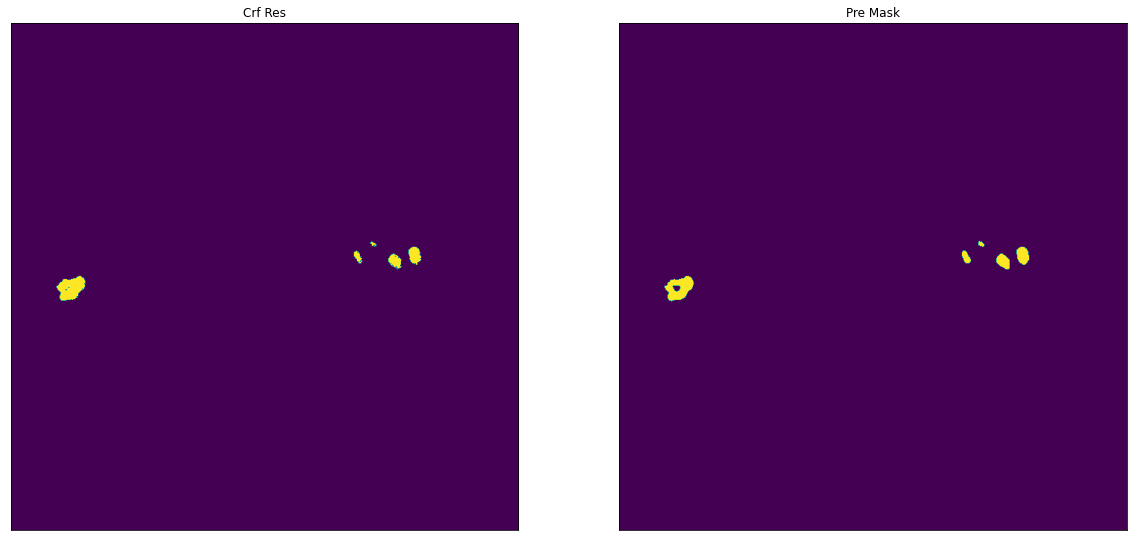

In [64]:
crf_res = np.argmax(result, axis=2)
visualize(crf_res=crf_res, pre_mask=pre_mask)

In [16]:
np.unique(crf_res)

array([0, 1])